MLP model for predicting filtered shear stress


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import statistics
import time
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import h5py


In [2]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)):
		end_ix = i + n_steps
		if end_ix > len(data):
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix-1, -1]  #last column is assumed to be the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)
 

In [3]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel(), 'Vel_pc':data['Vel_pc'].ravel()})  
df1 = a_t.merge(m_t, on='Time')

data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_run1_pp_wAmp.mat')
df2 = pd.DataFrame({'maxFreqI_filt':data2['maxFreqI_filt'][3786:136185].ravel(), 'freqQAmpI_filt':data2['freqQAmpI_filt'][3786:136185].ravel(),
                    'freqQAmpI_filt_pc':data2['freqQAmpI_filt_pc'].ravel()})

df = pd.concat([df1, df2], axis=1)

df = df[['freqQAmpI_filt', 'freqQAmpI_filt_pc', 'V_filt', 'Vel_pc', 'maxFreqI_filt', 'SS']]
print("Input data:\n", df)


Input data:
         freqQAmpI_filt  freqQAmpI_filt_pc  ...  maxFreqI_filt        SS
0         31453.223522                0.0  ...  457640.731368  5.656166
1         31438.277060                0.0  ...  457680.400524  5.657157
2         31421.341616                0.0  ...  457727.638932  5.658317
3         31409.798761                0.0  ...  457770.778724  5.659499
4         31398.815589                0.0  ...  457811.889181  5.660404
...                ...                ...  ...            ...       ...
132394    31055.686766                0.0  ...  454427.484288  5.471059
132395    31041.955345                0.0  ...  454414.128118  5.474545
132396    31035.059531                0.0  ...  454404.028108  5.478286
132397    31020.001291                0.0  ...  454403.709700  5.481751
132398    31012.016780                0.0  ...  454398.871858  5.484813

[132399 rows x 6 columns]


In [4]:
# Preprocessing

arr = df.to_numpy()
n_steps = 300
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

# Reshape features from 3D to 2D (for input layer)

in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))


Features shape, X =  (132100, 300, 5)
Target shape, Y =  (132100,)
After reshaping, X =  (132100, 1500)


In [5]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])


Training samples: 95112
Validation samples: 10568
Testing samples: 26420


Epoch 1/20
2973/2973 [==============================] - 9s 3ms/step - loss: 0.2475 - val_loss: 0.0664
Epoch 2/20
2973/2973 [==============================] - 8s 3ms/step - loss: 0.0457 - val_loss: 0.0468
Epoch 3/20
2973/2973 [==============================] - 8s 3ms/step - loss: 0.0267 - val_loss: 0.0266
Epoch 4/20
2973/2973 [==============================] - 8s 3ms/step - loss: 0.0111 - val_loss: 0.0052
Epoch 5/20
2973/2973 [==============================] - 8s 3ms/step - loss: 0.0031 - val_loss: 0.0070
Epoch 6/20
2973/2973 [==============================] - 8s 3ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 7/20
2973/2973 [==============================] - 8s 3ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/20
2973/2973 [==============================] - 9s 3ms/step - loss: 0.0011 - val_loss: 9.0766e-04
Epoch 9/20
2973/2973 [==============================] - 9s 3ms/step - loss: 9.3923e-04 - val_loss: 0.0011
Epoch 10/20
2973/2973 [==============================] - 9s 3ms/step - los

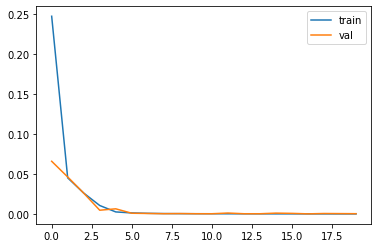

---Training time: 173.51476932 seconds ---


In [6]:
# Build the model

np.random.seed(0)   # To get reproducible results
#tf.random.set_seed(0)

model = Sequential()
model.add(Dense(128, kernel_initializer = 'normal', input_dim = in_dim, activation='relu'))
model.add(Dense(64, kernel_initializer = 'normal', activation='relu'))
model.add(Dense(32, kernel_initializer = 'normal', activation='relu'))
model.add(Dense(1, kernel_initializer = 'normal', activation='linear'))
model.compile(loss='mse', optimizer='adam')

start_time = time.time()
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))


In [7]:
# Save the model

print(model.summary())
#model.save('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/models/MLP_ss.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               192128    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 202,497
Trainable params: 202,497
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# Evaluate the model

y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

start_time = time.time()
y_predTest = model.predict(x_test)
end_time = time.time()
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("R2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_r2, val_r2, test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_rmse, val_rmse, test_rmse))

print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))


R2 scores: Train - 0.94251, Validation - 0.95846, Test - 0.91474
RMSE scores: Train - 0.03082, Validation - 0.03007, Test - 0.04219

---Time for Test data prediction: 1.00430179 seconds ---


In [ ]:
# Save
'''
hf = h5py.File('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/predictions/mlp_ss.h5', 'w')
hf.create_dataset('y_predTrain', data=y_predTrain)
hf.create_dataset('y_predVal', data=y_predVal)
hf.create_dataset('y_predTest', data=y_predTest)
hf.close()
'''

Text(0.5, 1.0, 'Shear Stress prediction using MLP model')

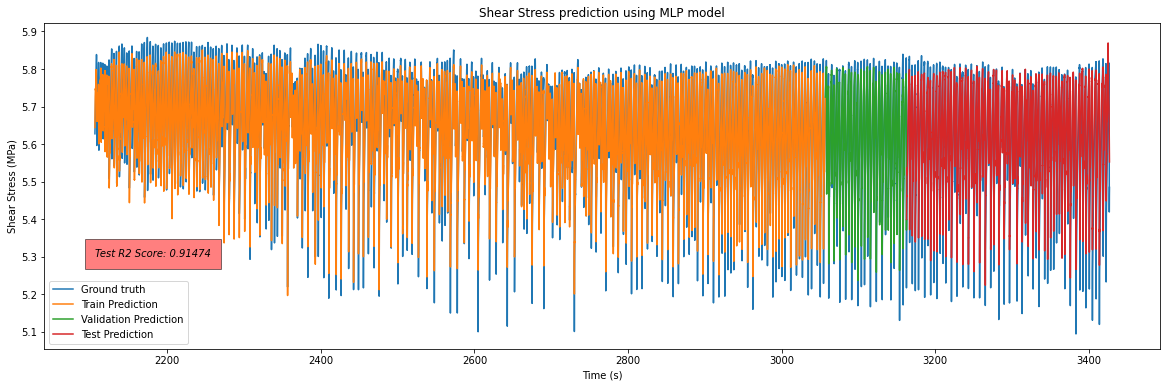

In [10]:
# Overall plot

ttime = df1['Time'][n_steps-1:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.1, shuffle=False)

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf)
plt.plot(traintime, y_predTrain)
plt.plot(valtime, y_predVal)
plt.plot(testtime, y_predTest)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.text(ttime.iloc[0], 5.3, 'Test R2 Score: %0.5f' %(test_r2), style='italic', bbox=dict(facecolor='red', alpha=0.5, pad=10))
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('Shear Stress prediction using MLP model')


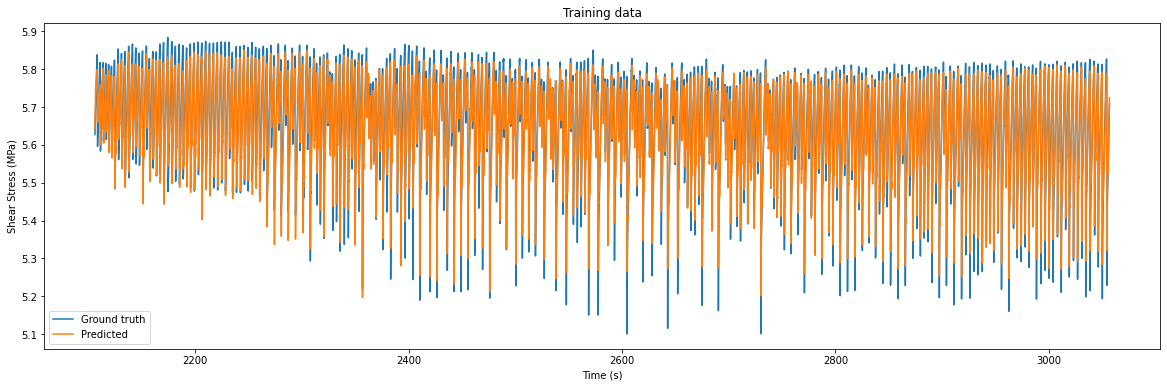

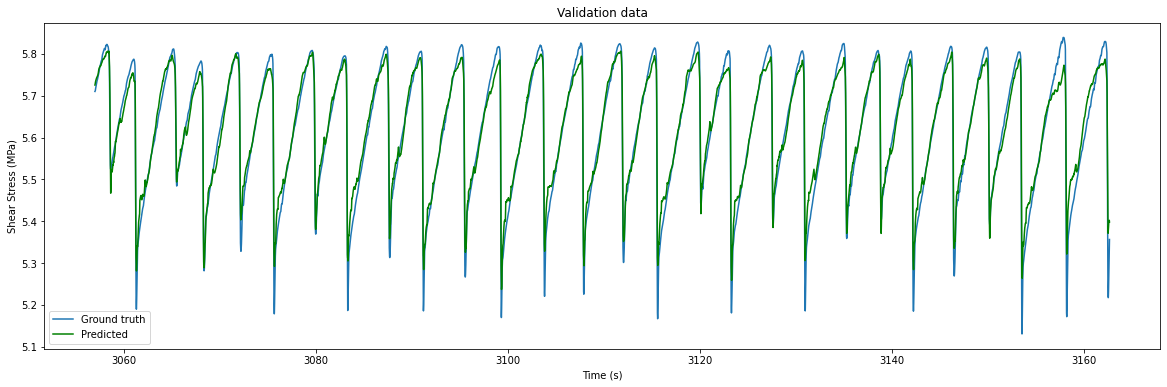

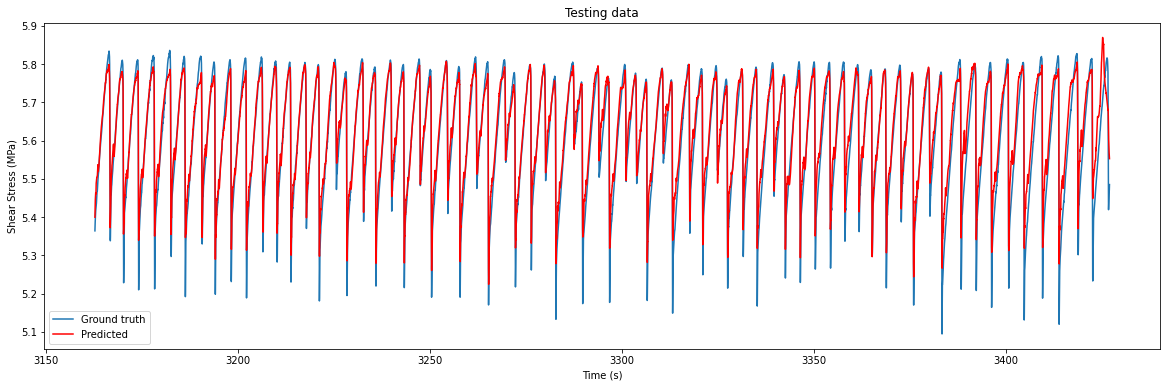

In [11]:
# Individual plots

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train, y_predTrain, 'Training data', '')
results_plot(2, valtime, Y_val, y_predVal, 'Validation data', 'g')
results_plot(3, testtime, y_test, y_predTest, 'Testing data', 'r')


Text(0.5, 1.0, 'Detailed View, Testing Data')

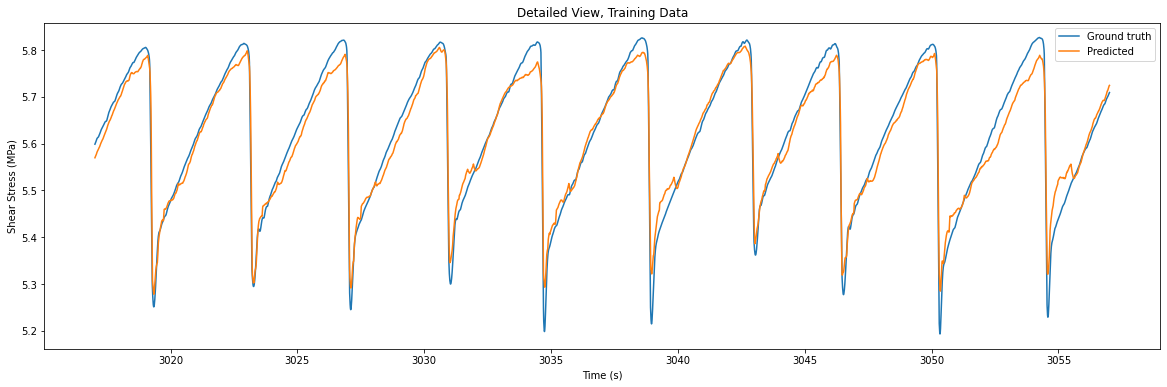

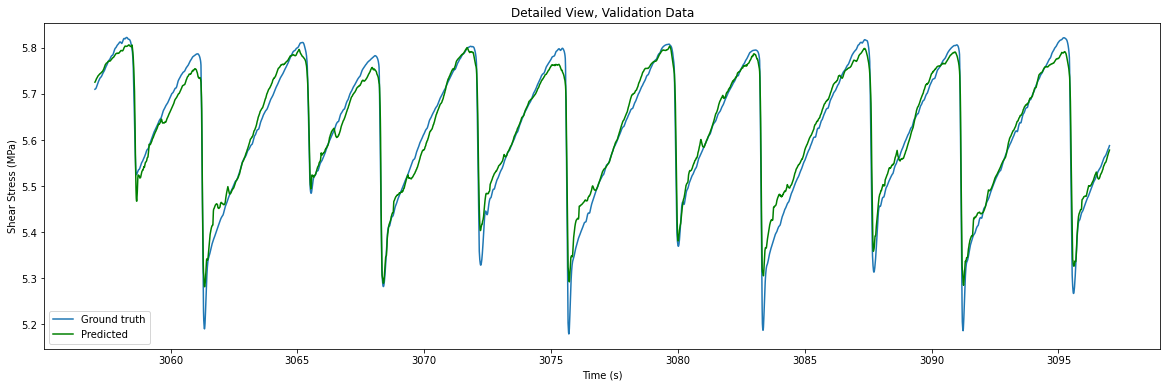

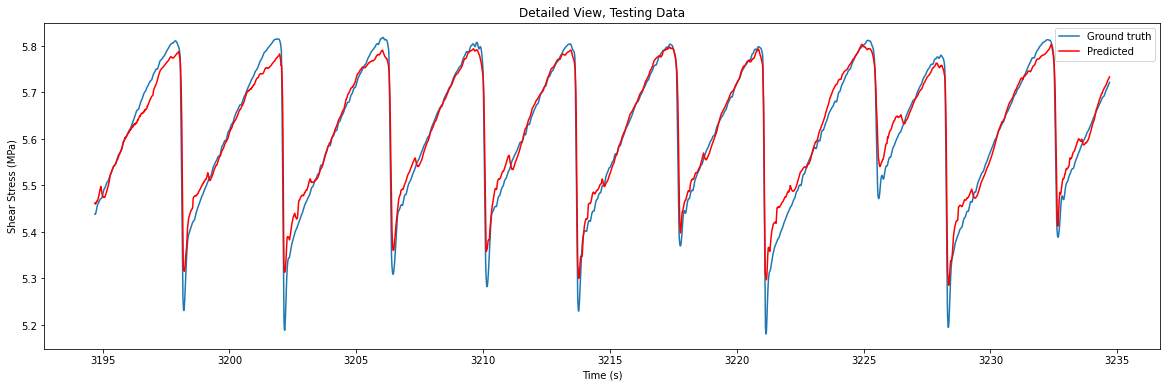

In [12]:
# Detailed view of the plots

n=4000

fig = plt.figure(4, figsize=(20,6))
plt.plot(traintime[-n:], Y_train[-n:])
plt.plot(traintime[-n:], y_predTrain[-n:])
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(valtime[:n], Y_val[:n])
plt.plot(valtime[:n], y_predVal[:n], 'g')
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Validation Data')

st_i = 3200
fig = plt.figure(6, figsize=(20,6))
plt.plot(testtime[st_i:st_i+n], y_test[st_i:st_i+n])
plt.plot(testtime[st_i:st_i+n], y_predTest[st_i:st_i+n], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')


Text(0.5, 1.0, 'Shear Stress')

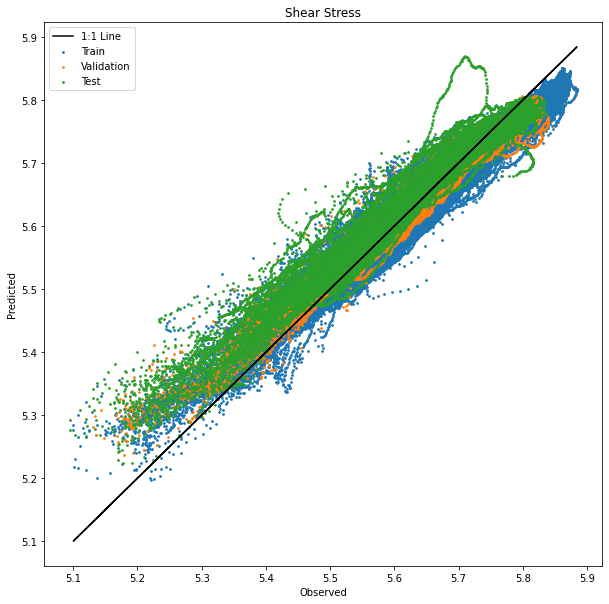

In [13]:

# Regression analysis
fig = plt.figure(7, figsize=(10,10))
plt.plot(Y_train, Y_train, 'black')
plt.scatter(Y_train, y_predTrain, s=3)
plt.scatter(Y_val, y_predVal, s=3)
plt.scatter(y_test, y_predTest, s=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(['1:1 Line','Train', 'Validation', 'Test'])
plt.title('Shear Stress')
